In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import time
import datetime
import xarray

from mpl_toolkits.basemap import Basemap
import glob
import os
import shutil
import subprocess
import sys 

%pylab inline
pylab.rcParams['figure.figsize'] = (16, 10) # Large figures
pylab.rcParams['image.cmap'] = 'seismic'
dpi=200;

/lus/theta-fs0/projects/ccsm/acme/tools/e3sm-unified/base/envs/e3sm_unified_1.2.5_py3.7_nox/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/lus/theta-fs0/projects/ccsm/acme/tools/e3sm-unified/base/envs/e3sm_unified_1.2.5_py3.7_nox/lib/python3.7/site-packages/distributed/utils.py:134: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)


Populating the interactive namespace from numpy and matplotlib


In [2]:
### axis_font = {'fontname':'Arial', 'size':'18'}    
title_font = {'fontname':'Arial', 'size':'32', 'color':'black', 'weight':'normal'}
matplotlib.rc('xtick', labelsize=28)
matplotlib.rc('ytick', labelsize=28)

In [3]:
from netCDF4 import Dataset

In [4]:
mesh = xarray.open_dataset('/lus/theta-fs0/projects/ccsm/acme/inputdata/ocn/mpas-o/oRRS18to6v3/oRRS18to6v3_80Layer.restartFromAnvil.171031.nc')

In [25]:
nedges = mesh.dims['nEdges']
nVertices = mesh.dims['nVertices']
vertexDeg = mesh.dims['vertexDegree']
ncells = mesh.dims['nCells']
maxedge = mesh.dims['maxEdges']
edgesOnVertex = mesh.edgesOnVertex.values
nEdgesOnCell = mesh.nEdgesOnCell.values
cellsOnEdge = mesh.cellsOnEdge.values
verticesOnCell = mesh.verticesOnCell.values
angleEdge = mesh.angleEdge.values
dcEdge = mesh.dcEdge.values
dvEdge = mesh.dvEdge.values
areaTriangle = mesh.areaTriangle.values
edgesOnCell = mesh.edgesOnCell.values
verticesOnEdge = mesh.verticesOnEdge.values
kiteAreasOnVertex = mesh.kiteAreasOnVertex.values
cellsOnVertex = mesh.cellsOnVertex.values

In [29]:
areaCell = mesh.areaCell.values

In [46]:
fEdge = mesh.fEdge.values

In [9]:
edgeSignOnCell = np.zeros((maxedge,ncells))
for icell in range(ncells):
    for i in range(nEdgesOnCell[icell]):
        iedge = edgesOnCell[icell,i]-1
        ivertex = verticesOnCell[icell,i]-1
        
        if icell==cellsOnEdge[iedge,1]:
            edgeSignOnCell[i,icell] = -1
        else:
            edgeSignOnCell[i,icell]=1

In [27]:
kiteIndexOnCell = np.zeros((ncells,maxedge))
for icell in range(ncells):
    for i in range(nEdgesOnCell[icell]):
        iedge = edgesOnCell[icell,i]-1
        ivertex = verticesOnCell[icell,i]-1

        for j in range(vertexDeg):
            if cellsOnVertex[ivertex,j] == icell:
                kiteIndexOnCell[icell,i] = j

In [45]:
edgeSignOnVertex = np.zeros((vertexDeg,nVertices))
for ivertex in range(nVertices):
    for i in range(vertexDeg):
        iedge = edgesOnVertex[ivertex,i]-1
        if ivertex == verticesOnEdge[iedge,0]:
            edgeSignOnVertex[i,ivertex] = -1
        else:
            edgeSignOnVertex[i,ivertex] = 1

In [12]:
ds = xarray.open_dataset('/lus/theta-fs0/projects/ClimateEnergy_3/lvanroek/windstress/mpaso.hist.am.timeSeriesStatsMonthly.0007-01-01.nc')
wsm = ds.timeMonthly_avg_windStressMeridional[0,:].values
wsz = ds.timeMonthly_avg_windStressZonal[0,:].values

In [13]:
#compute stress on edges
edgestress = np.zeros(nedges)
for iedge in range(nedges):
    cell1 = cellsOnEdge[iedge,0]-1
    cell2 = cellsOnEdge[iedge,1]-1
    
    zonalAv = 0.5*(wsz[cell1]+wsz[cell2])
    meridAv = 0.5*(wsm[cell1]+wsm[cell2])
    
    edgestress[iedge] = edgestress[iedge] + np.cos(angleEdge[iedge])*zonalAv + np.sin(angleEdge[iedge])*meridAv

In [47]:
#compute curl at vertices
curlwind = np.zeros(nVertices)
for ivertex in range(nVertices):
    invarea = 1.0/areaTriangle[ivertex]
    for i in range(vertexDeg):
        iedge = edgesOnVertex[ivertex,i]-1
        r_tmp = dcEdge[iedge]*edgestress[iedge]/fEdge[iedge]
        curlwind[ivertex] = curlwind[ivertex] + edgeSignOnVertex[i,ivertex]*r_tmp*invarea

In [48]:
#interpolate to cell centers
curlwindCent = np.zeros(ncells)
for icell in range(ncells):
    invarea = 1.0 / areaCell[icell]
    for i in range(nEdgesOnCell[icell]):
        j = int(kiteIndexOnCell[icell,i]) 
        ivertex = verticesOnCell[icell,i]-1
        curlwindCent[icell] = curlwindCent[icell] + kiteAreasOnVertex[ivertex,j] * invarea * curlwind[ivertex]

(0.5, 1)

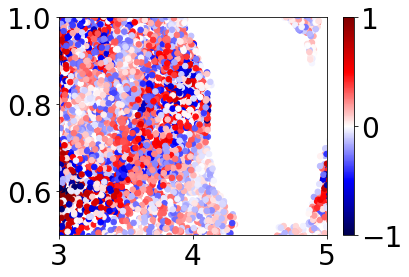

In [53]:
plt.scatter(mesh.lonVertex[::120],mesh.latVertex[::120],s=30,c=curlwind[::120],vmin=-1,vmax=1)
plt.colorbar()
plt.xlim(3,5)
plt.ylim(0.5,1)